<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/childcare_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 子育てスコア
- input
    - public_school_score.csv
        - 幼稚園スコア
    - nursery_score.csv
        - 保育園スコア
        - 児童館スコア
- output
    - childcare_score.csv
        - 子育てスコア


In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
score_name = '子育てスコア'
output_score_file = 'childcare_score.csv'

### 人口マスタ

In [6]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[[
    '地域ID', '市区町村名', '町名', '町丁目'
]].set_index('地域ID')
print(df_pop_master.shape)

(3145, 3)


### 学校スコア

In [7]:
df_school_score = pd.read_csv(os.path.join(DIR_NAME, 'public_school_score.csv'))[[
    '地域ID', '幼稚園スコア',
]].set_index('地域ID')
print(df_school_score.shape)

(3145, 1)


In [8]:
df_school_score.head()

,幼稚園スコア
地域ID,
101003,2.293
101004,1.935
101005,2.736
101007,2.449
101008,2.948


### 保育園

In [9]:
df_nursery_score = pd.read_csv(os.path.join(DIR_NAME, 'nursery_score.csv'))[[
    '地域ID', '保育園スコア', '児童館スコア'
]].set_index('地域ID')
print(df_nursery_score.shape)

(3145, 2)


In [10]:
df_nursery_score.head()

,保育園スコア,児童館スコア
地域ID,,
101003,0.125,0.367
101004,0.093,0.200
101005,0.127,0.280
101007,0.208,0.395
101008,0.236,0.652


In [11]:
def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

### 子育てスコア

In [12]:
df_score = pd.concat([
    df_pop_master,
    df_school_score,
    df_nursery_score
], axis=1)
print(df_score.shape)
assert len(df_score) == len(df_pop_master)
df_pop_master = df_score

(3145, 6)


In [13]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 6)


,市区町村名,町名,町丁目,幼稚園スコア,保育園スコア,児童館スコア
地域ID,,,,,,
101003,千代田区,丸の内,丸の内１丁目,2.293,0.125,0.367
101004,千代田区,丸の内,丸の内２丁目,1.935,0.093,0.200
101005,千代田区,丸の内,丸の内３丁目,2.736,0.127,0.280
101007,千代田区,大手町,大手町１丁目,2.449,0.208,0.395
101008,千代田区,大手町,大手町２丁目,2.948,0.236,0.652


In [14]:
feature_list = {
    '幼稚園スコア': {'sort': 1, 'weight': 1},
    '保育園スコア': {'sort': 1, 'weight': 1},
    '児童館スコア': {'sort': 1, 'weight': 1},
}

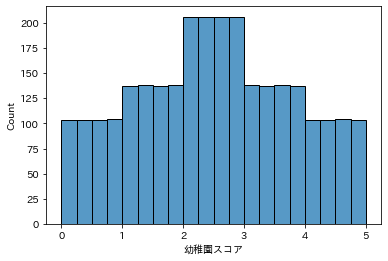

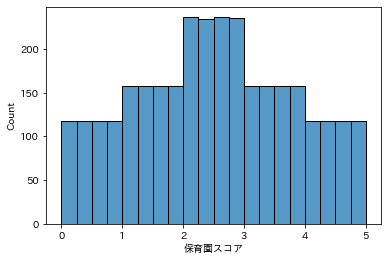

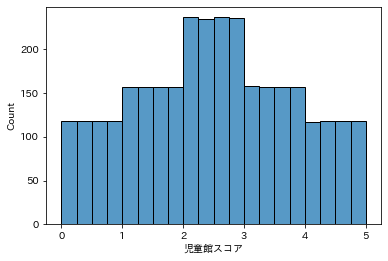

In [15]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [16]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score)

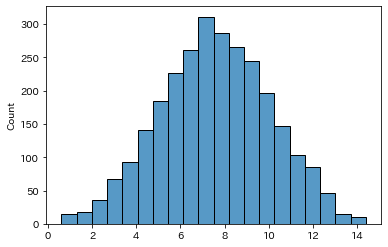

In [17]:
sns.histplot(_tmp_score, bins=20)
plt.show()

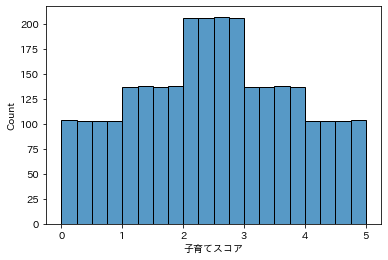

In [18]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [19]:
df_pop_master[score_name] = df_pop_master[score_name].round(3)

In [20]:
df_pop_master[
    list(feature_list.keys()) + [score_name]
].to_csv(os.path.join(DIR_NAME, output_score_file), index=True)

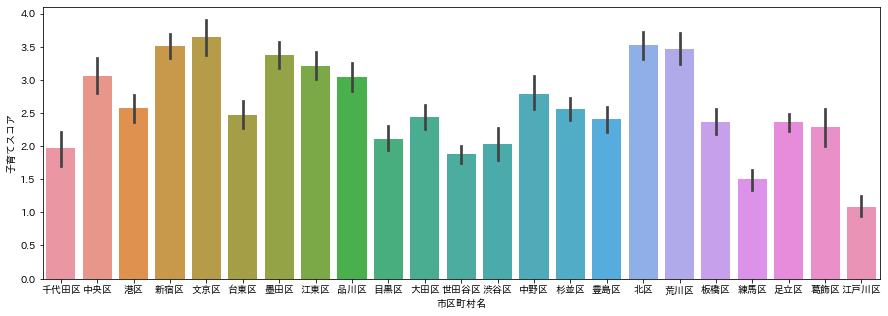

In [21]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_pop_master)
plt.show()

In [22]:
df_level = df_pop_master.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + list(feature_list.keys()) + [score_name]
].reset_index(drop=True)
print(df_level.shape)

(852, 7)


In [23]:
df_level.head(10)

,市区町村名,町名,町丁目,幼稚園スコア,保育園スコア,児童館スコア,子育てスコア
0,文京区,水道,水道１丁目,4.639,4.817,4.938,5.000
1,品川区,西大井,西大井６丁目,4.869,4.527,4.985,4.998
2,北区,西が丘,西が丘２丁目,4.973,4.474,4.800,4.995
3,新宿区,中町,中町,4.486,4.868,4.862,4.993
4,江東区,千田,千田,4.939,4.622,4.646,4.990
5,荒川区,町屋,町屋１丁目,4.789,4.499,4.847,4.988
6,新宿区,東五軒町,東五軒町,4.263,4.904,4.949,4.985
7,新宿区,南町,南町,4.476,4.841,4.722,4.983
8,台東区,谷中,谷中５丁目,4.864,4.215,4.915,4.981
9,文京区,小日向,小日向３丁目,4.896,4.389,4.665,4.978


In [24]:
df_level.tail(10)

,市区町村名,町名,町丁目,幼稚園スコア,保育園スコア,児童館スコア,子育てスコア
842,足立区,古千谷,古千谷１丁目,0.158,0.108,2.250,0.138
843,江戸川区,東篠崎町,東篠崎町,1.988,0.344,0.127,0.128
844,足立区,舎人公園,舎人公園,0.145,0.119,2.134,0.112
845,大田区,東海,東海１丁目,1.925,0.068,0.289,0.099
846,世田谷区,砧公園,砧公園,1.066,0.221,0.611,0.073
847,渋谷区,神山町,神山町,0.029,1.116,0.482,0.058
848,大田区,京浜島,京浜島１丁目,1.130,0.074,0.221,0.044
849,大田区,城南島,城南島７丁目,1.245,0.023,0.042,0.039
850,大田区,羽田空港,羽田空港１丁目,0.735,0.102,0.261,0.019
851,千代田区,千代田,千代田,0.332,0.087,0.304,0.005
